In [1]:
%matplotlib inline
import pandas as pd
from datetime import datetime

### File preparation

To prepare the file and be able to read it properly, the following sed commands must be used:

```sh
sed -i '1s/^/[/' data/file.json # Starts JSON array
sed -i -e 's/}/},/g' data/file.json # Separate objects with commas
sed -i '$ s/,$/]/g' data/file.json # Ends JSON array
```

### Data importation

We will start by focusing on one specific product subsection, here video games.

In [2]:
video_games = pd.read_json('./data/video-games.json')

# Cleaning dates
del video_games['reviewTime'] # Duplicated information (already in unix review time)
video_games['date'] = pd.to_datetime(video_games['unixReviewTime'], unit='s')
del video_games['unixReviewTime']

video_games.set_index(['asin', 'reviewerID'], inplace=True)
video_games.dtypes

helpful                 object
overall                  int64
reviewText              object
reviewerName            object
summary                 object
date            datetime64[ns]
dtype: object

### Data cleaning

In [3]:
def helpful_rate(row):
    was_helpful = row.helpful[0]
    total_evaluations = row.helpful[1]
    
    if total_evaluations == 0:
        return 0
    
    return was_helpful/total_evaluations

video_games['helpfulRate'] = video_games.apply(helpful_rate, axis=1)

assert video_games.index.is_unique # There is no more than one review per person per product

video_games.head()

helpful  overall  \
asin       reviewerID                         
0700099867 A2HD75EMZR8QLN  [8, 12]        1   
           A3UR8NLLY1ZHCX   [0, 0]        4   
           A1INA0F5CWW3J4   [0, 0]        1   
           A1DLMTOTHQ4AST  [7, 10]        3   
           A361M14PU2GUEG   [2, 2]        4   

                                                                  reviewText  \
asin       reviewerID                                                          
0700099867 A2HD75EMZR8QLN  Installing the game was a struggle (because of...   
           A3UR8NLLY1ZHCX  If you like rally cars get this game you will ...   
           A1INA0F5CWW3J4  1st shipment received a book instead of the ga...   
           A1DLMTOTHQ4AST  I got this version instead of the PS3 version,...   
           A361M14PU2GUEG  I had Dirt 2 on Xbox 360 and it was an okay ga...   

                                                 reviewerName  \
asin       reviewerID                                           
0700099867 A2HD75EMZR8QLN                                 123   
           A3UR8NLLY1ZHCX  Alejandro Henao "Electronic Junky"   
           A1INA0F5CWW3J4          Amazon Shopper "Mr.Repsol"   
           A1DLMTOTHQ4AST                            ampgreen   
           A361M14PU2GUEG        Angry Ryan "Ryan A. Forrest"   

                                                                   summary  \
asin       reviewerID                                                        
0700099867 A2HD75EMZR8QLN         Pay to unlock content? I don't think so.   
           A3UR8NLLY1ZHCX                                  Good rally game   
           A1INA0F5CWW3J4                                        Wrong key   
           A1DLMTOTHQ4AST  awesome game, if it did not crash frequently !!   
           A361M14PU2GUEG                                           DIRT 3   

                                date  helpfulRate  
asin       reviewerID                              
0700099867 A2HD75EMZR8QLN 2012-07-09     0.666667  
           A3UR8NLLY1ZHCX 2013-06-30     0.000000  
           A1INA0F5CWW3J4 2014-06-28     0.000000  
           A1DLMTOTHQ4AST 2011-09-14     0.700000  
           A361M14PU2GUEG 2011-06-14     1.000000

### Descriptive analysis

We now start by looking at the repartition of evaluations, considering all the sold products.

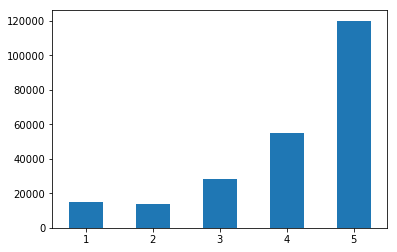

In [4]:
video_games.overall.value_counts(ascending=True).sort_index().plot(kind='bar', rot=0)

50.82% of reviews are evaluated


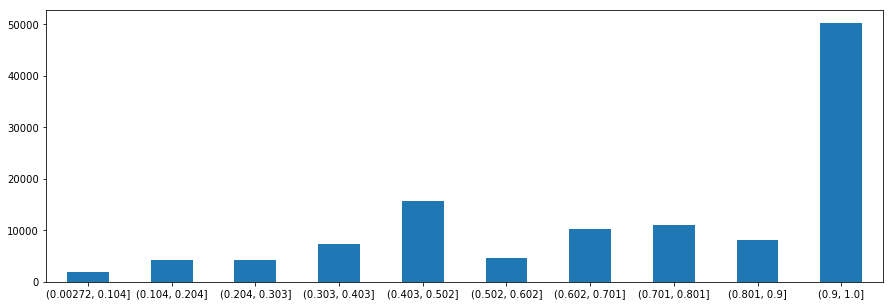

In [5]:
# We get all the "helpfulness rates" (removing the unrated comments)
helpfulRates = video_games[video_games.helpfulRate > 0].helpfulRate

print(str(round(len(helpfulRates) * 100 / len(video_games.helpfulRate), 2)) + '% of reviews are evaluated')

helpfulRates.value_counts(ascending=True, bins=10).sort_index().plot(kind='bar', rot=0, figsize=(15, 5))

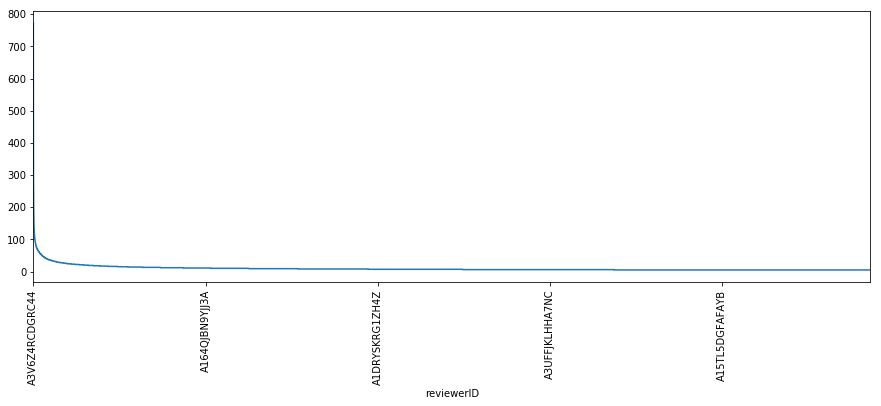

In [6]:
count_evaluations = video_games.groupby('reviewerID').count().sort_values('helpful', ascending=False).helpful

count_evaluations.plot(rot=90, figsize=(15, 5))

Zooming to get only evaluators with more than 30 evaluations. We can see that evaluations are done by a restricted number of evaluators providing the majority of evaluations.

1st best evaluator: 773
2nd best evaluator: 635
3rd best evaluator: 450
4th best evaluator: 404
5th best evaluator: 320


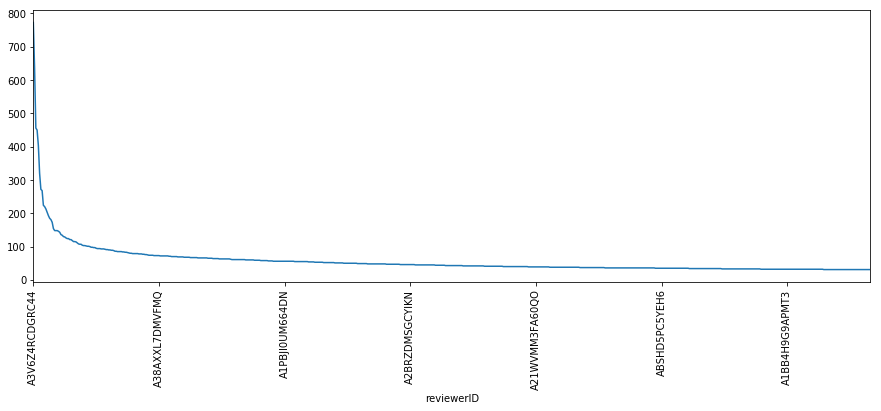

In [7]:
top_count_evaluations = count_evaluations[count_evaluations > 30]
top_count_evaluations.plot(rot=90, figsize=(15, 5))

print('1st best evaluator: ' + str(top_count_evaluations[0]))
print('2nd best evaluator: ' + str(top_count_evaluations[1]))
print('3rd best evaluator: ' + str(top_count_evaluations[3]))
print('4th best evaluator: ' + str(top_count_evaluations[4]))
print('5th best evaluator: ' + str(top_count_evaluations[5]))

Focusing on the best evaluator, let's see if he provides well rated evaluations:

In [8]:
best_reviewer_id = top_count_evaluations.index[0]

video_games.groupby('reviewerID').get_group(best_reviewer_id).mean()

overall        4.316947
helpfulRate    0.762964
dtype: float64

Comparing it with all the others.

In [9]:
video_games.overall.mean()

4.0863965829666062

In [11]:
video_games[video_games.helpfulRate > 0].helpfulRate.mean()

0.73898469315193238